In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import os
import sys
import pickle
import numpy as np
import torch
import pandas as pd
sys.path.append("/home/wangrr/Analysis/epiRNA/src")
import epiRNA as erna

workdir = "/data/wangrr/Analysis/epiRNA/workdir2/filter"
os.makedirs(workdir, exist_ok=True); os.chdir(workdir)

import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

## <span style="font-family: Arial, sans-serif;">1. Load trained model and get filter weights

In [ ]:
checkpoints = "/data/wangrr/Analysis/epiRNA/models/basic_fold/version_0/checkpoints/epoch=18-step=215327-val_ePCC_mixed=0.7823.ckpt"

config_file = "/home/wangrr/Analysis/epiRNA/src/experiments/model_v2/configs/basic_model.yaml"

model = erna.evals.load_model(ckpt=checkpoints, config_yaml=config_file)

In [4]:
filter_weights = model.get_convolution_weights()[0] # get weights of first conv layer, numpy array
filter_weights.shape

(512, 4, 17)

## <span style="font-family: Arial, sans-serif;">2. Weights to position weighted matrix
* <span style="font-family: Arial, sans-serif;"> Extract weights, method 1: Directly convert weights to PWM.
* <span style="font-family: Arial, sans-serif;"> Extract weights, method 2: Screen over validation sequence and get windows with maximum activation.

In [5]:
# Method 1: via softmax the kernel weights (temperature set to std of absolute weight values)
direct_pwms = erna.ex.get_pwm_from_weights(torch.from_numpy(filter_weights))
direct_pwms.shape

torch.Size([512, 4, 17])

* <span style="font-family: Arial, sans-serif;">For the second method, we follow Koo et al.'s work:
![../asset/filter_viz_method.png](/home/wangrr/Analysis/epiRNA_analysis/asset/filter_viz_method.png)

In [6]:
datainfo = pd.read_excel("/home/wangrr/Analysis/epiRNA/data/mRNA_multiomic_sample_info.xlsx", sheet_name="m6A")

m6A_train_samples = ["TIME-1", "mHeart-1"] # each sample each species is enough

datainfo = datainfo[datainfo["SID"].isin(m6A_train_samples)].reset_index(drop=True)

ref_dir = "/data/wangrr/Analysis/epiRNA/Dataset/Reference"
genome = {
    "human":{
        "fasta": f"{ref_dir}/Homo_sapiens.GRCh38.dna.primary_assembly.84.fa",
        "gtf": f"{ref_dir}/Homo_sapiens.GRCh38.84.gtf"
    },
    "mouse":{
        "fasta": f"{ref_dir}//Mus_musculus.GRCm38.dna.primary_assembly.84.fa",
        "gtf": f"{ref_dir}/Mus_musculus.GRCm38.84.gtf"
    }
}

human_gtf_df = erna.pp.GTFLoader(gtf_path=genome["human"]["gtf"], zero_based=True)
mouse_gtf_df = erna.pp.GTFLoader(gtf_path=genome["mouse"]["gtf"], zero_based=True)

chrom_kwargs = {
    'human': {
        'train_chroms': ["1", "2", "3", "4", "5", "6", "7", "9", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22"],
        'val_chroms': ["8"],
        'test_chroms': ["10"]
    },
    'mouse': {
        'train_chroms': ["1", "2", "3", "4", "5", "6", "7", "9", "11", "12", "13", "14", "15", "16", "17", "18", "19"],
        'val_chroms': ["8"],
        'test_chroms': ["10"]
    }
}

rbp_dict_file = "/home/wangrr/Analysis/epiRNA/data/rbp_expression_dict.pkl"
with open(rbp_dict_file, "rb") as f:
    rbp_dict = pickle.load(f)

dataset_kwargs = {
    'human_fasta_path': genome["human"]["fasta"],
    'mouse_fasta_path': genome["mouse"]["fasta"],
    "modality_to_index": {"m6A_human": 0, "m6A_mouse": 1},
    'bigwig_dir': "/data/wangrr/Analysis/epiRNA/Dataset/processed/4-coverage",
    'datainfo': datainfo,
    'rbp_dict': rbp_dict['rbp_dict'],
    'human_gtf_df': human_gtf_df,
    'mouse_gtf_df': mouse_gtf_df,
    'return_bin_input': True,
    'seq_len': 65536,
    'mask_type': None
}

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']


In [7]:
datamodule = erna.ds.GeneDataModule(
    dataset_cls=erna.ds.GeneDataset,
    dataset_kwargs=dataset_kwargs,
    chrom_kwargs=chrom_kwargs,
    batch_size=32,
    num_workers=8
)
datamodule.setup(stage="test")

Total samples: 36266
Omics types: ['m6A']
Total samples: 1721
Omics types: ['m6A']
Total samples: 1753
Omics types: ['m6A']


In [8]:
# # Time and memory consuming step
# all_pcms = []
# for i in range(filter_weights.shape[0]):
#     weight = torch.from_numpy(filter_weights)[i:i+1,:,: ]
#     conv_layer = torch.nn.Conv1d(
#         in_channels=4,
#         out_channels=weight.shape[0],
#         kernel_size=weight.shape[2],
#         bias=False,
#         padding="same"
#     )
#     conv_layer.weight = torch.nn.Parameter(weight)
#     conv_layer.eval()
    
#     pcm = erna.ex.get_max_activated_windows(
#         dataloader=datamodule.val_dataloader(),
#         conv_layer=conv_layer,
#         activate_fn=None,
#         threshold_frac=0.5,
#         device="cuda:0"
#     )
#     pcm = pcm[0]
#     all_pcms.append(pcm)

In [9]:
# # save pcm to npy
# all_pcms = np.array(all_pcms)
# np.save("filter_pwms.npy", all_pcms)

all_pcms = np.load("filter_pwms.npy")
# PCM to PWM (normalize)
window_pwms = []
for pcm in all_pcms:
    # norm ACGU channel, make sum to 1
    pwm = pcm / np.sum(pcm, axis=0, keepdims=True)
    window_pwms.append(pwm)
window_pwms = np.array(window_pwms)

## <span style="font-family: Arial, sans-serif;">3. Motif Preview

Text(0, 0.5, 'Bits')

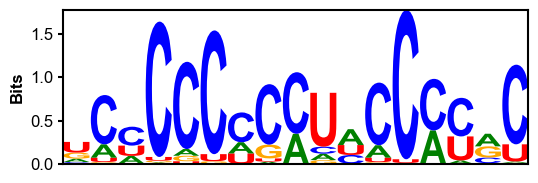

In [102]:
# preview in bits
from epiRNA.explain.motif_utils import pwm_to_bits
idx = 224-1
ax = erna.pl.logoplot(
    pwm_to_bits(window_pwms[idx]).T, 
    title=f"",
    figsize=(6, 2)
)
ax.set_ylabel("Bits")

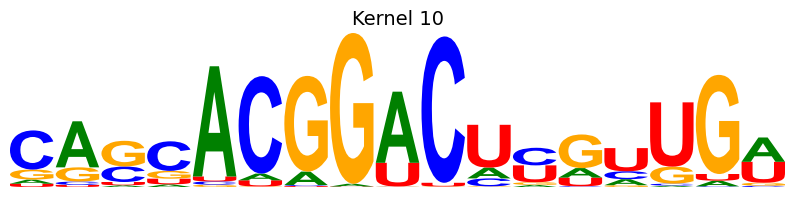

In [11]:
ax = erna.pl.logoplot(
    pwm_to_bits(direct_pwms[idx]).T, 
    title=f"Kernel {idx}",
    figsize=(10, 2)
)

## <span style="font-family: Arial, sans-serif;">4. Write to MEME format

In [12]:
for alphabet in ["ACGU", "ACGT"]:
    conv_meme_file = os.path.join(workdir, f"direct_converted.{alphabet}.meme")
    erna.ex.write_pwms(direct_pwms, filename=conv_meme_file, basename="filter_direct", alphabet=alphabet)

Wrote MEME to /data/wangrr/Analysis/epiRNA/workdir2/filter/direct_converted.ACGU.meme
Wrote MEME to /data/wangrr/Analysis/epiRNA/workdir2/filter/direct_converted.ACGT.meme


In [13]:
for alphabet in ["ACGU", "ACGT"]:
    conv_meme_file = os.path.join(workdir, f"window_counted.{alphabet}.meme")
    erna.ex.write_pwms(torch.from_numpy(window_pwms), filename=conv_meme_file, basename="filter_window", alphabet=alphabet)

Wrote MEME to /data/wangrr/Analysis/epiRNA/workdir2/filter/window_counted.ACGU.meme
Wrote MEME to /data/wangrr/Analysis/epiRNA/workdir2/filter/window_counted.ACGT.meme


## <span style="font-family: Arial, sans-serif;">5. Load RBP databases and annotate


In [14]:
# Add MEME bin to PATH
meme_bin = "/nvme/biosoft/softwares/Meme-Suite/5.5.8/meme/bin/"
os.environ["PATH"] += f":{meme_bin}"

In [15]:
motifdb_dir = "/data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed"
RBP_databases = [
    os.path.join(motifdb_dir, name) for name in os.listdir(motifdb_dir)
    if (name.startswith("cisbp") or name.startswith("ATtRACT") or name.startswith("ENCORI") and name.endswith(".meme"))
]
RBP_databases = sorted(RBP_databases)
RBP_databases

['/data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed/ATtRACT_human.meme',
 '/data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed/ATtRACT_mouse.meme',
 '/data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed/ENCORI_human.meme',
 '/data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed/ENCORI_mouse.meme',
 '/data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed/cisbp-rna_human.meme',
 '/data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed/cisbp-rna_mouse.meme']

In [61]:
TF_databases = [
    os.path.join(motifdb_dir, name) for name in os.listdir(motifdb_dir)
    if (name.startswith("hocomoco") or name.startswith("jaspar") and name.endswith(".meme"))
]
TF_databases = sorted(TF_databases)
TF_databases

['/data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed/hocomoco_human.meme',
 '/data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed/hocomoco_mouse.meme',
 '/data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed/jaspar_human.meme',
 '/data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed/jaspar_mouse.meme']

In [16]:
# # Time consuming step
# for database in RBP_databases:
#     alphabet = "ACGU"
#     conv_meme_file = os.path.join(workdir, f"direct_converted.{alphabet}.meme")
#     output = os.path.join(
#         workdir, 
#         "tomtom_results_direct_converted", 
#         f"filter_{os.path.basename(database).split('.')[0]}"
#     )
#     os.makedirs(output, exist_ok=True)
#     erna.ex.tomtom(
#         meme=conv_meme_file,
#         database=database,
#         output=output,
#         seqtype="RNA"
#     )

In [17]:
# for database in RBP_databases:
#     alphabet = "ACGU"
#     conv_meme_file = os.path.join(workdir, f"window_counted.{alphabet}.meme")
#     output = os.path.join(
#         workdir, 
#         "tomtom_results_window_counted", 
#         f"filter_{os.path.basename(database).split('.')[0]}",
#     )
#     os.makedirs(output, exist_ok=True)
#     erna.ex.tomtom(
#         meme=conv_meme_file,
#         database=database,
#         output=output,
#         seqtype="RNA"
#     )

In [63]:
for database in TF_databases:
    alphabet = "ACGT"
    conv_meme_file = os.path.join(workdir, f"window_counted.{alphabet}.meme")
    output = os.path.join(
        workdir, 
        "tomtom_results_window_counted", 
        f"filter_{os.path.basename(database).split('.')[0]}",
    )
    os.makedirs(output, exist_ok=True)
    erna.ex.tomtom(
        meme=conv_meme_file,
        database=database,
        output=output,
        seqtype="DNA"
    )

Running command: tomtom -oc /data/wangrr/Analysis/epiRNA/workdir2/filter/tomtom_results_window_counted/filter_hocomoco_human -dist pearson /data/wangrr/Analysis/epiRNA/workdir2/filter/window_counted.ACGT.meme /data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed/hocomoco_human.meme


The output directory '/data/wangrr/Analysis/epiRNA/workdir2/filter/tomtom_results_window_counted/filter_hocomoco_human' already exists.
Its contents will be overwritten.
Processing query 1 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 2716 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00392
#   Estimated pi_0=1
Processing query 2 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 2716 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00392
#   Estimated pi_0=1
Processing query 3 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 2716 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00243
#   Estimated pi_0=1
Processing query 4 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 2716 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00354
#   Estimated pi_0=1
Processing query 5 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 2716 observed p-values.
#   Estimating pi_0.

Running command: tomtom -oc /data/wangrr/Analysis/epiRNA/workdir2/filter/tomtom_results_window_counted/filter_hocomoco_mouse -dist pearson /data/wangrr/Analysis/epiRNA/workdir2/filter/window_counted.ACGT.meme /data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed/hocomoco_mouse.meme


The output directory '/data/wangrr/Analysis/epiRNA/workdir2/filter/tomtom_results_window_counted/filter_hocomoco_mouse' already exists.
Its contents will be overwritten.
Processing query 1 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 2004 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00452
#   Estimated pi_0=1
Processing query 2 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 2004 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00452
#   Estimated pi_0=1
Processing query 3 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 2004 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00302
#   Estimated pi_0=1
Processing query 4 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 2004 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00302
#   Estimated pi_0=1
Processing query 5 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 2004 observed p-values.
#   Estimating pi_0.

Running command: tomtom -oc /data/wangrr/Analysis/epiRNA/workdir2/filter/tomtom_results_window_counted/filter_jaspar_human -dist pearson /data/wangrr/Analysis/epiRNA/workdir2/filter/window_counted.ACGT.meme /data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed/jaspar_human.meme


The output directory '/data/wangrr/Analysis/epiRNA/workdir2/filter/tomtom_results_window_counted/filter_jaspar_human' already exists.
Its contents will be overwritten.
Processing query 1 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 1714 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00444
#   Estimated pi_0=1
Processing query 2 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 1714 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00444
#   Estimated pi_0=1
Processing query 3 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 1714 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00327
#   Estimated pi_0=1
Processing query 4 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 1714 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00092
#   Estimated pi_0=1
Processing query 5 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 1714 observed p-values.
#   Estimating pi_0.
#

Running command: tomtom -oc /data/wangrr/Analysis/epiRNA/workdir2/filter/tomtom_results_window_counted/filter_jaspar_mouse -dist pearson /data/wangrr/Analysis/epiRNA/workdir2/filter/window_counted.ACGT.meme /data/wangrr/Analysis/epiRNA/Dataset/motifdb/processed/jaspar_mouse.meme


The output directory '/data/wangrr/Analysis/epiRNA/workdir2/filter/tomtom_results_window_counted/filter_jaspar_mouse' already exists.
Its contents will be overwritten.
Processing query 1 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 314 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 2 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 314 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00503
#   Estimated pi_0=1
Processing query 3 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 314 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00182
#   Estimated pi_0=1
Processing query 4 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 314 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.997233
#   Estimated pi_0=0.998624
Processing query 5 out of 512 
# Computing q-values.
#   Estimating pi_0 from all 314 observed p-values.
#   Estimating pi_0

## <span style="font-family: Arial, sans-serif;">6. Merge and save tomtom results

In [18]:
rbp_result = pd.DataFrame()
for method in ["window_counted", "direct_converted"]:
    conv_meme_file = os.path.join(workdir, f"{method}.ACGU.meme")
    for database in RBP_databases:
        tomtom_output = os.path.join(workdir, f"tomtom_results_{method}", f"filter_{os.path.basename(database).split('.')[0]}", "tomtom.tsv")
        
        df = pd.read_csv(tomtom_output, sep="\t", comment="#")
        df["Name"] = df["Target_ID"].apply(lambda x: x.split("|")[1])
        df["Organism"] = df["Target_ID"].apply(lambda x: x.split("|")[-1])
        df["Source"] = df["Target_ID"].apply(lambda x: x.split("_")[0])
        rbp_result = pd.concat([rbp_result, df], axis=0)
        
    rbp_result = rbp_result.reset_index(drop=True)
    rbp_result = rbp_result[~rbp_result["Name"].isin(['Unknown', "unknown"])]
    rbp_result["Type"] = "RBP"
    rbp_result.to_csv(f"{method}_tomtom_RBP_hits.csv", index=False)


In [64]:
tf_result = pd.DataFrame()
for method in ["window_counted"]:
    conv_meme_file = os.path.join(workdir, f"{method}.ACGT.meme")
    for database in TF_databases:
        tomtom_output = os.path.join(workdir, f"tomtom_results_{method}", f"filter_{os.path.basename(database).split('.')[0]}", "tomtom.tsv")
        
        df = pd.read_csv(tomtom_output, sep="\t", comment="#")
        df["Name"] = df["Target_ID"].apply(lambda x: x.split("|")[1])
        df["Organism"] = df["Target_ID"].apply(lambda x: x.split("|")[-1])
        df["Source"] = df["Target_ID"].apply(lambda x: x.split("_")[0])
        tf_result = pd.concat([tf_result, df], axis=0)
        
    tf_result = tf_result.reset_index(drop=True)
    tf_result = tf_result[~tf_result["Name"].isin(['Unknown', "unknown"])]
    tf_result["Type"] = "TF"
    tf_result.to_csv(f"{method}_tomtom_TF_hits.csv", index=False)


In [65]:
tf_result

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation,Name,Organism,Source,Type
0,filter_window_width17_3,HOCOMOCO_TEAD1.H13CORE.1.P.C|TEAD1|Homo_sapiens,-2,0.000021,0.028411,0.031774,13,GAACTTTCCTTGCATTC,ACATTCCTGGCAT,+,TEAD1,Homo_sapiens,HOCOMOCO,TF
1,filter_window_width17_3,HOCOMOCO_TEAD1.H13CORE.2.S.C|TEAD1|Homo_sapiens,-1,0.000023,0.031774,0.031774,16,GAACTTTCCTTGCATTC,TACATTCCTTACATTCCAA,+,TEAD1,Homo_sapiens,HOCOMOCO,TF
2,filter_window_width17_3,HOCOMOCO_TEAD3.H13CORE.1.S.B|TEAD3|Homo_sapiens,-1,0.000167,0.226562,0.151041,16,GAACTTTCCTTGCATTC,CACATTCCTCGCATTCCA,+,TEAD3,Homo_sapiens,HOCOMOCO,TF
3,filter_window_width17_3,HOCOMOCO_ZN582.H13CORE.0.P.C|ZN582|Homo_sapiens,-6,0.000374,0.508060,0.254030,11,GAACTTTCCTTGCATTC,TACTTGCAGCC,-,ZN582,Homo_sapiens,HOCOMOCO,TF
4,filter_window_width17_3,HOCOMOCO_Z324A.H13CORE.0.P.B|Z324A|Homo_sapiens,6,0.000619,0.840573,0.336229,17,GAACTTTCCTTGCATTC,GGGATCAAACCATCCTTTGCTGCC,+,Z324A,Homo_sapiens,HOCOMOCO,TF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3821,filter_window_width17_499,JASPAR_MA0111.1|Spz1|Mus_musculus,-5,0.000632,0.099184,0.065608,11,TCCTAAGGGGATCAGGT,AGGGTAACAGC,+,Spz1,Mus_musculus,JASPAR,TF
3822,filter_window_width17_501,JASPAR_MA0897.2|Hmx2|Mus_musculus,-1,0.000176,0.027644,0.055287,15,ACAGCCCATGATGGATC,AAGCAATTAAAGAAT,+,Hmx2,Mus_musculus,JASPAR,TF
3823,filter_window_width17_509,JASPAR_MA0494.2|Nr1h3::Rxra|Mus_musculus,1,0.000289,0.045306,0.089975,15,GGATCGCTTAGGTCAAA,AGGTTACTTTAGGTCA,-,Nr1h3::Rxra,Mus_musculus,JASPAR,TF
3824,filter_window_width17_509,JASPAR_MA1604.2|Ebf2|Mus_musculus,-3,0.002109,0.331160,0.328835,9,GGATCGCTTAGGTCAAA,TCCCTTGGG,-,Ebf2,Mus_musculus,JASPAR,TF


## <span style="font-family: Arial, sans-serif;">7. Search DRACH motif

In [19]:
tomtom_df = pd.read_csv(f"{method}_tomtom_RBP_hits.csv", comment="#")
tomtom_df.head()

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation,Name,Organism,Source,Type
0,filter_window_width17_2,ATtRACT_889|HNRNPH1|Homo_sapiens,0,0.001063,1.26911,0.26928,5,AGAGAUAGAUCACUCUG,AGAGA,+,HNRNPH1,Homo_sapiens,ATtRACT,RBP
1,filter_window_width17_2,ATtRACT_941|HNRNPH2|Homo_sapiens,0,0.001063,1.26911,0.26928,5,AGAGAUAGAUCACUCUG,AGAGA,+,HNRNPH2,Homo_sapiens,ATtRACT,RBP
2,filter_window_width17_2,ATtRACT_992|PTBP1|Homo_sapiens,-9,0.001738,2.07491,0.26928,6,AGAGAUAGAUCACUCUG,UCUCUC,+,PTBP1,Homo_sapiens,ATtRACT,RBP
3,filter_window_width17_2,ATtRACT_21|NELFE|Homo_sapiens,-7,0.001992,2.37893,0.26928,10,AGAGAUAGAUCACUCUG,GGUCUCUCUG,+,NELFE,Homo_sapiens,ATtRACT,RBP
4,filter_window_width17_2,ATtRACT_597|DAZAP1|Homo_sapiens,0,0.002306,2.75303,0.26928,6,AGAGAUAGAUCACUCUG,AGAUAU,+,DAZAP1,Homo_sapiens,ATtRACT,RBP


In [20]:
import re
drach_pattern = re.compile(r'[AG][AG]AC[ACU]')
drach_hits = []
for idx, row in rbp_result.iterrows():
    query_consensus = row["Query_consensus"]
    if drach_pattern.search(query_consensus):
        drach_hits.append(True)
    else:
        drach_hits.append(False)
tomtom_df["DRACH_in_Query"] = drach_hits

hit = tomtom_df[tomtom_df["DRACH_in_Query"] == True].copy()
print(hit.Query_ID.unique())

['filter_window_width17_3' 'filter_window_width17_22'
 'filter_window_width17_44' 'filter_window_width17_62'
 'filter_window_width17_75' 'filter_window_width17_76'
 'filter_window_width17_95' 'filter_window_width17_100'
 'filter_window_width17_103' 'filter_window_width17_115'
 'filter_window_width17_132' 'filter_window_width17_145'
 'filter_window_width17_149' 'filter_window_width17_156'
 'filter_window_width17_167' 'filter_window_width17_178'
 'filter_window_width17_180' 'filter_window_width17_182'
 'filter_window_width17_211' 'filter_window_width17_215'
 'filter_window_width17_223' 'filter_window_width17_227'
 'filter_window_width17_235' 'filter_window_width17_237'
 'filter_window_width17_242' 'filter_window_width17_249'
 'filter_window_width17_261' 'filter_window_width17_269'
 'filter_window_width17_271' 'filter_window_width17_285'
 'filter_window_width17_304' 'filter_window_width17_309'
 'filter_window_width17_312' 'filter_window_width17_329'
 'filter_window_width17_343' 'filter_wi

In [33]:
import epiRNA as erna

Text(0, 0.5, 'Bits')

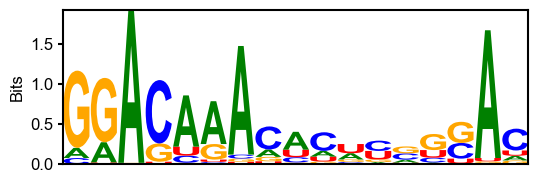

In [60]:
# preview in bits
idx = 115
ax = erna.pl.logoplot(
    pwm_to_bits(window_pwms[idx-1]).T, 
    title=f"",
    figsize=(6, 2)
)
ax.set_ylabel("Bits", fontweight='regular')

1-based: 464, 434, 377, 372, 343, 324, 311, 270, 247, 225, 223, 185, 165, 62, 44, 32, 227, 115

In [186]:
import matplotlib.pyplot as plt
for i in range(len(hit.Query_ID.unique())):
    idx = int(hit.Query_ID.unique()[i].split("_")[-1])
    ax = erna.pl.logoplot(
        pwm_to_bits(window_pwms[idx-1]).T, 
        title=f"Kernel {idx}",
        figsize=(10, 2)
    )
    plt.savefig(f"/home/wangrr/Analysis/epiRNA_analysis/filter/motif_figure/Kernel_{idx}_DRACH_motif.png")
    plt.close()

## For TF

In [118]:
tf_result = pd.read_csv(f"{method}_tomtom_TF_hits.csv", comment="#")

In [122]:
tf_result_filter = tf_result[tf_result["q-value"] < 0.05].copy()
np.sort(tf_result_filter.Name.unique()).tolist()

['ATMIN',
 'Ascl2',
 'Atf3',
 'BACH1',
 'BATF',
 'BATF3',
 'BATF::JUN',
 'BNC2',
 'CLOCK',
 'Dlx2',
 'Dlx5',
 'EHF',
 'ELF1',
 'ELF3',
 'ELK1',
 'ELK3',
 'ERF',
 'ETS1',
 'ETS2',
 'ETV1',
 'ETV2',
 'ETV2::FIGLA',
 'ETV2::FOXI1',
 'ETV3',
 'ETV4',
 'ETV5',
 'Ebf2',
 'Ebf4',
 'Erg',
 'FEV',
 'FLI1',
 'FOS',
 'FOS::JUN',
 'FOS::JUNB',
 'FOS::JUND',
 'FOSB::JUNB',
 'FOSL1',
 'FOSL1::JUN',
 'FOSL1::JUNB',
 'FOSL2::JUN',
 'FOSL2::JUNB',
 'FOSL2::JUND',
 'FOXJ2::ELF1',
 'Fosb',
 'HNF4A',
 'HNF4G',
 'Hmx1',
 'Hmx3',
 'Ikzf3',
 'JDP2',
 'JUNB',
 'JUND',
 'Jun',
 'KLF10',
 'KLF11',
 'KLF12',
 'KLF13',
 'KLF14',
 'KLF15',
 'KLF17',
 'KLF8',
 'KLF9',
 'MAZ',
 'MEF2B',
 'MGA',
 'MYNN',
 'NFAC2',
 'Nfe2l2',
 'Nr2F6',
 'PATZ1',
 'PAX3',
 'PBX3',
 'PKNOX1',
 'PRDM1',
 'Rarb',
 'Rarg',
 'SCRT2',
 'SP4',
 'SPIB',
 'Spi1',
 'Spz1',
 'Stat4',
 'Stat5a',
 'Stat5a::Stat5b',
 'Stat5b',
 'Stat6',
 'TEAD1',
 'TET3',
 'VDR',
 'VEZF1',
 'Vdr',
 'Wt1',
 'ZBT17',
 'ZBT49',
 'ZBT7A',
 'ZBTB40',
 'ZEB1',
 'ZN132',
 

In [131]:
'CEBPZ' in tf_result_filter.Name.unique()

False

In [123]:
tf_result_filter

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation,Name,Organism,Source,Type
0,filter_window_width17_3,HOCOMOCO_TEAD1.H13CORE.1.P.C|TEAD1|Homo_sapiens,-2,0.000021,0.028411,0.031774,13,GAACTTTCCTTGCATTC,ACATTCCTGGCAT,+,TEAD1,Homo_sapiens,HOCOMOCO,TF
1,filter_window_width17_3,HOCOMOCO_TEAD1.H13CORE.2.S.C|TEAD1|Homo_sapiens,-1,0.000023,0.031774,0.031774,16,GAACTTTCCTTGCATTC,TACATTCCTTACATTCCAA,+,TEAD1,Homo_sapiens,HOCOMOCO,TF
31,filter_window_width17_63,HOCOMOCO_ZBT49.H13CORE.0.P.C|ZBT49|Homo_sapiens,1,0.000014,0.019429,0.038858,17,TGACCAGAGAGGCATAA,GTGACCAGCCAGGCCAAAATGGG,+,ZBT49,Homo_sapiens,HOCOMOCO,TF
45,filter_window_width17_106,HOCOMOCO_VDR.H13CORE.0.PS.A|VDR|Homo_sapiens,0,0.000004,0.006026,0.012052,16,TGGACCCAGTGAACTCT,TGAACCCAGTGACCTC,-,VDR,Homo_sapiens,HOCOMOCO,TF
57,filter_window_width17_114,HOCOMOCO_ZN284.H13CORE.0.P.C|ZN284|Homo_sapiens,0,0.000010,0.013960,0.027921,16,TATCGTGCCAGAGCGCC,GATCGCACCACTGCAC,-,ZN284,Homo_sapiens,HOCOMOCO,TF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3757,filter_window_width17_446,JASPAR_MA1988.2|Atf3|Mus_musculus,-10,0.000126,0.019760,0.019451,7,CATGTGGAGTTGACTCA,TGACTCA,+,Atf3,Mus_musculus,JASPAR,TF
3758,filter_window_width17_446,JASPAR_MA2486.1|Fosb|Mus_musculus,-10,0.000126,0.019760,0.019451,7,CATGTGGAGTTGACTCA,TGACTCA,+,Fosb,Mus_musculus,JASPAR,TF
3759,filter_window_width17_446,JASPAR_MA0489.3|Jun|Mus_musculus,-10,0.000365,0.057379,0.037655,7,CATGTGGAGTTGACTCA,TGACTCAT,+,Jun,Mus_musculus,JASPAR,TF
3819,filter_window_width17_499,JASPAR_MA1604.2|Ebf2|Mus_musculus,-1,0.000248,0.039007,0.045993,9,TCCTAAGGGGATCAGGT,CCCAAGGGA,+,Ebf2,Mus_musculus,JASPAR,TF


Text(0, 0.5, 'Bits')

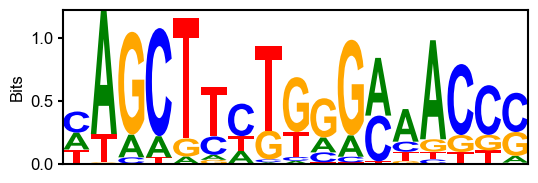

In [134]:
# preview in bits
idx = 282
ax = erna.pl.logoplot(
    pwm_to_bits(window_pwms[idx]).T, 
    title=f"",
    figsize=(6, 2),
    alphabet="ACGT"
)
ax.set_ylabel("Bits", fontweight='regular')

In [135]:
human_gtf_df

,chrom,source,feature,start,end,score,strand,frame,gene_id,gene_version,...,havana_transcript,havana_transcript_version,tag,transcript_support_level,exon_number,exon_id,exon_version,ccds_id,protein_id,protein_version
0,1,ensembl_havana,gene,69090,70008,NaN,+,0,ENSG00000186092,4,...,,,,,,,,,,
1,1,ensembl,gene,182392,184158,NaN,+,0,ENSG00000279928,1,...,,,,,,,,,,
2,1,ensembl,gene,184922,200322,NaN,-,0,ENSG00000279457,3,...,,,,,,,,,,
3,1,ensembl_havana,gene,450739,451678,NaN,-,0,ENSG00000278566,1,...,,,,,,,,,,
4,1,ensembl_havana,gene,685715,686654,NaN,-,0,ENSG00000273547,1,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19821,KI270726.1,ensembl,gene,26240,26534,NaN,+,0,ENSG00000277856,1,...,,,,,,,,,,
19822,KI270726.1,ensembl,gene,41443,41876,NaN,+,0,ENSG00000275063,1,...,,,,,,,,,,
19823,KI270711.1,ensembl,gene,4611,29626,NaN,-,0,ENSG00000271254,6,...,,,,,,,,,,
19824,KI270713.1,ensembl,gene,31697,32528,NaN,-,0,ENSG00000277475,1,...,,,,,,,,,,


In [139]:
human_gtf_df.feature.unique()

['gene']
Categories (9, object): ['gene', 'transcript', 'exon', 'CDS', ..., 'stop_codon', 'five_prime_utr', 'three_prime_utr', 'Selenocysteine']